***

# $\text{Utilizing Machine Learning for High Frequency Algorithmic Trading}$


#### **$\textbf{Name:}$** $\text{Masixole Boya}$

**$\textbf{Student number:}$**  $\text{1869204}$

***
### __Key Objectives__ 
- Get a site that can supply the data
  - Retrieve the data from this site, import into my file
  - Get used to the format the data is retrieved in (*.i.e.* in JSON, in this case)
- Get the model training on this data
  - Train the model in the format of retreival or format it into a format suitable for training

# __Table of Contents__

- [0. Imports](#0-imports)
- [1. Requesting the data](#1-requesting-the-data)
  - [1.1 API Parameters](#11-api-parameters)
- [2. Analysis & Processing](#2-analysis--processing)
  - [2.1 Basic Analysis](#21-basic-analysis)
  - [2.2 Preprocessing](#22-preprocessing)
    - [2.2.1 Scaling](#221-scaling)
    - [2.2.2 Creating training data](#222-creating-training-data)
    - [2.2.3 Splitting: Training, Validation, Testing Data](#223-splitting-training-validation-testing-data)
- [3. Training the model](#224-training-the-model)
- [4. Model Evaluation](#3-model-evaluation)


# __0. Imports__

In [1]:
from secret_key import Secret
import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import pytz

2024-03-18 21:19:57.835496: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 21:19:57.838259: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 21:19:57.875556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 21:19:58.542697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1>
    <b>1. Requesting the data </b> : Tiingo API
</h1>
<h4><i> Here I explain the 'parameters' that the <b>api url</b> requires</i></h4>
<h4>The `tiingo` API gives `intraday data` which seems to <b><i>delay by 10 mins</i></b> from real time, and top-of-book data. Here, I shall train with the intraday data, but I will still request the top-of-book to analyse how different it is. The smallest time unit for this API  is <b>1 minute<b/></h4>

<h2>
    <b>1.1 API Parameters</b>
</h2>
<ul>
    <li>
        <strong> Ticker</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li><u>DATA TYPE:</u>  string
            </li>
            <li><u>REQUIRED:</u>
            </li>
        </ul>
    </li>
    <li> 
        <strong>Start Date</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong>End Date</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong> Resample Freq</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string (e.g. "15min" or "4hour". )
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: 5min
            </li>
        </ul>
    </li>
    <li>
        <strong>Response Format</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: JSON
            </li>
        </ul>
    </li>
</ul>


In [2]:
headers =  {
    'Content-Type' : 'application/json'
}

In [3]:
ticker = 'EURUSD'
start_date = '2024-03-01'
end_date = '2024-03-19'
resample_freq = '5min'


<h2>
    <b>1.2 Requesting Intraday Data</b>
</h2>

In [4]:
# requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/{ticker.lower()}/prices?startDate={start_date}&resampleFreq={resample_freq}&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)

requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/{ticker.lower()}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={resample_freq}&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)


In [5]:
data = requestResponse.json() 
data 

[{'date': '2024-03-01T00:00:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080585,
  'high': 1.080765,
  'low': 1.080545,
  'close': 1.080625},
 {'date': '2024-03-01T00:05:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080615,
  'high': 1.080835,
  'low': 1.080545,
  'close': 1.08081},
 {'date': '2024-03-01T00:10:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08082,
  'high': 1.08089,
  'low': 1.08082,
  'close': 1.080885},
 {'date': '2024-03-01T00:15:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08088,
  'high': 1.080945,
  'low': 1.08081,
  'close': 1.08088},
 {'date': '2024-03-01T00:20:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080885,
  'high': 1.080935,
  'low': 1.080865,
  'close': 1.08088},
 {'date': '2024-03-01T00:25:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080875,
  'high': 1.080905,
  'low': 1.080775,
  'close': 1.080775},
 {'date': '2024-03-01T00:30:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08078,
  'high': 1.08082,
  'low': 1.080775,
  'close': 1.080785},
 {'date': '2024-03-01T0

In [6]:
last_data_item = data[-1]  
print("Last data item:", last_data_item)

utc_time_str = '2024-03-18T21:10:00.000Z'
sa_time = datetime.strptime(utc_time_str, '%Y-%m-%dT%H:%M:%S.%fZ').replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Africa/Johannesburg'))

#South African time
print("South African Time:", sa_time.strftime('%Y-%m-%d %H:%M:%S'))



Last data item: {'date': '2024-03-18T21:20:00.000Z', 'ticker': 'eurusd', 'open': 1.08739, 'high': 1.08739, 'low': 1.087385, 'close': 1.087385}
South African Time: 2024-03-18 23:10:00



<h2>
    <b>1.3 Requesting Top-Of-Book Data</b>
</h2>

#### This shows the latest price - at the exact time of running this cell

In [7]:
requestResponseTOB = requests.get(f"https://api.tiingo.com/tiingo/fx/top?tickers={ticker.lower()}&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)
tob_data = requestResponseTOB.json()
tob_data

[{'ticker': 'eurusd',
  'quoteTimestamp': '2024-03-18T21:20:27.162000+00:00',
  'bidPrice': 1.08726,
  'bidSize': 1000000.0,
  'askPrice': 1.08753,
  'askSize': 1000000.0,
  'midPrice': 1.087395}]

# __2. Analysis & Processing__

<h2><strong>2.1 Basic Analysis</strong></h2>

In [8]:
df= pd.DataFrame(data)
df.shape

(3426, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3426 non-null   object 
 1   ticker  3426 non-null   object 
 2   open    3426 non-null   float64
 3   high    3426 non-null   float64
 4   low     3426 non-null   float64
 5   close   3426 non-null   float64
dtypes: float64(4), object(2)
memory usage: 160.7+ KB


#### I use the `df.tail()` method to be able to see the __latest__ time the data ends at.

In [10]:
df.tail()

,date,ticker,open,high,low,close
3421,2024-03-18T20:55:00.000Z,eurusd,1.087175,1.087270,1.087175,1.087270
3422,2024-03-18T21:05:00.000Z,eurusd,1.087305,1.087470,1.087295,1.087295
3423,2024-03-18T21:10:00.000Z,eurusd,1.087290,1.087355,1.087275,1.087330
3424,2024-03-18T21:15:00.000Z,eurusd,1.087320,1.087400,1.087310,1.087390
3425,2024-03-18T21:20:00.000Z,eurusd,1.087390,1.087390,1.087385,1.087385


In [11]:
type(df['date'])


pandas.core.series.Series

In [12]:
df['date'] = pd.to_datetime(df['date'])


In [13]:
df.set_index('date', inplace=True)


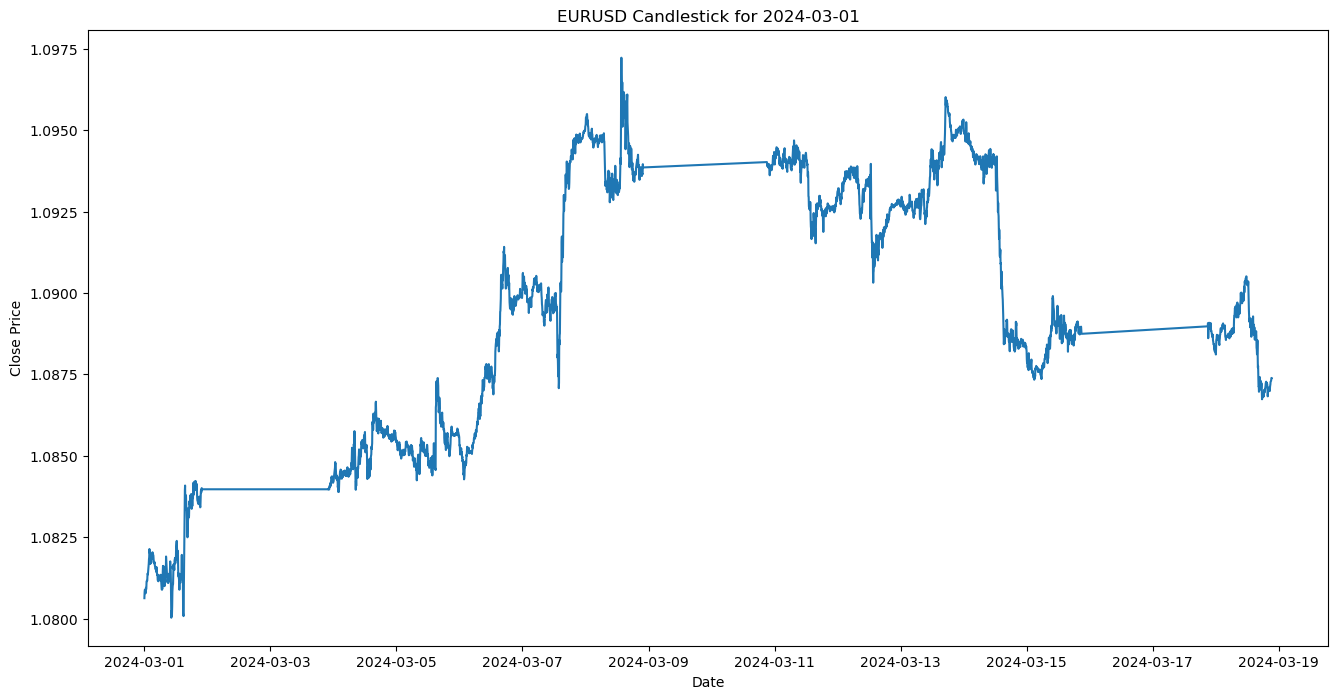

In [14]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Candlestick for {start_date}')
plt.plot(df['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

<h2><strong>2.2 Preprocessing</strong></h2>

<h3><strong>2.2.1 Scaling<strong></h3>

In [15]:
scaler = StandardScaler()
numerical_features = ['open', 'high', 'low', 'close']  # Assuming these are your numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [16]:

df.head()

,ticker,open,high,low,close
date,,,,,
2024-03-01 00:00:00+00:00,eurusd,-2.240688,-2.224052,-2.223714,-2.232647
2024-03-01 00:05:00+00:00,eurusd,-2.233223,-2.206642,-2.223714,-2.186587
2024-03-01 00:10:00+00:00,eurusd,-2.182218,-2.192962,-2.155241,-2.167914
2024-03-01 00:15:00+00:00,eurusd,-2.167290,-2.179282,-2.157731,-2.169159
2024-03-01 00:20:00+00:00,eurusd,-2.166045,-2.181769,-2.144036,-2.169159


<h3><strong>2.2.2 Creating training data<strong></h3>

<h4><strong>Preparing Lagged Data</strong></h4>

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [17]:
def create_lagged_dataframe(df, lag_steps=5):
    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']

    #Creating lagged columns for previous values
    for i in range(1, lag_steps + 1):
        lagged_df[f'PrevValue_{i}'] = df['close'].shift(i)

    return lagged_df.dropna()

lagged_df = create_lagged_dataframe(df)
lagged_df.head()


,DateTime,ActualValue,PrevValue_1,PrevValue_2,PrevValue_3,PrevValue_4,PrevValue_5
date,,,,,,,
2024-03-01 00:25:00+00:00,2024-03-01 00:25:00+00:00,-2.195301,-2.169159,-2.169159,-2.167914,-2.186587,-2.232647
2024-03-01 00:30:00+00:00,2024-03-01 00:30:00+00:00,-2.192812,-2.195301,-2.169159,-2.169159,-2.167914,-2.186587
2024-03-01 00:35:00+00:00,2024-03-01 00:35:00+00:00,-2.152976,-2.192812,-2.195301,-2.169159,-2.169159,-2.167914
2024-03-01 00:40:00+00:00,2024-03-01 00:40:00+00:00,-2.165424,-2.152976,-2.192812,-2.195301,-2.169159,-2.169159
2024-03-01 00:45:00+00:00,2024-03-01 00:45:00+00:00,-2.150486,-2.165424,-2.152976,-2.192812,-2.195301,-2.169159


<h4><strong>Prepare LSTM Data</strong></h4>

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [18]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values


dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (3421,)
X shape: (3421, 5)
y shape: (3421,)


<h3><strong>2.2.3 <u>Spliting:</u> Training, Validation, Testing Data<strong></h3>

<h4><strong>Split Data</strong></h4>

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [19]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [20]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 2052 instances ( 59.9824612686349 %)
Validation set: 684 instances ( 19.994153756211634 %)
Testing set: 685 instances ( 20.023384975153462 %)



# __3. Training the model__

In [21]:
model = Sequential([layers.Input((5,1)), # 3 because we are doing 3 past time units
                    layers.LSTM(60),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(1)]) 

model.compile(loss = 'mse', 
              optimizer =  Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error']
              )

2024-03-18 21:20:04.679625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 21:20:04.681169: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
history = model.fit(x_train,y_train, epochs = 100, verbose=1)

Epoch 1/100


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4687 - mean_absolute_error: 0.5203
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0086 - mean_absolute_error: 0.0704
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048 - mean_absolute_error: 0.0484
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - mean_absolute_error: 0.0486
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0467
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0444
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0444
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0428
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042 - mean_absolute_error: 0.0429
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0424
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10m

<h1><strong>4. Model Evaluation</strong></h1>

In [23]:
history


In [24]:
from sklearn.metrics import r2_score

loss, mae = model.evaluate(x_test, y_test, verbose=0)

#Evaluating on the test data
predictions = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print('Test Loss:', loss)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

# # Actual vs. predicted
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# loss curve
# history = model.history.history
# plt.figure(figsize=(10, 6))
# plt.plot(history['loss'], label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Loss: 0.0037387453485280275
Mean Absolute Error: 0.04585530608892441
Root Mean Squared Error: 0.061019257
R-squared: 0.9963140814400528
